# MomentsLD Parameter Analysis

This notebook provides an analysis of MomentsLD optimization results, comparing ground truth parameters with estimated values.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Configuration
EXPERIMENT_NAME = 'split_isolation'  # Change this to your experiment
BASE_PATH = Path(f'/home/akapoor/kernlab/Infer_Demography/experiments/{EXPERIMENT_NAME}')
SIMULATIONS_PATH = BASE_PATH / 'simulations'
INFERENCES_PATH = BASE_PATH / 'inferences'

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Simulations path: {SIMULATIONS_PATH}")
print(f"Inferences path: {INFERENCES_PATH}")
print(f"Paths exist: {SIMULATIONS_PATH.exists()}, {INFERENCES_PATH.exists()}")

Experiment: split_isolation
Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/simulations
Inferences path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/inferences
Paths exist: True, True


In [10]:
def load_ground_truth(simulations_path):
    """Load ground truth parameters from simulation directories."""
    gt_data = {}
    
    for sim_dir in sorted(simulations_path.iterdir()):
        if not sim_dir.is_dir():
            continue
        # Accept directories named as numbers (e.g., '0', '1', ...)
        if not sim_dir.name.isdigit():
            continue
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                gt_data[sim_id] = params
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
    
    print(f"Loaded ground truth for {len(gt_data)} simulations")
    return gt_data

def load_coverage_data(simulations_path):
    """Load coverage percentage data from bgs.meta.json files."""
    coverage_data = {}
    
    for sim_dir in sorted(simulations_path.iterdir()):
        if not sim_dir.is_dir():
            continue
        if not sim_dir.name.isdigit():
            continue
        sim_id = sim_dir.name
        meta_file = sim_dir / 'bgs.meta.json'
        if meta_file.exists():
            try:
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                coverage_data[sim_id] = meta.get('sampled_coverage_percent', None)
            except Exception as e:
                print(f"Error loading {meta_file}: {e}")
                coverage_data[sim_id] = None
        else:
            coverage_data[sim_id] = None
    
    print(f"Loaded coverage data for {len(coverage_data)} simulations")
    valid_coverage = sum(1 for v in coverage_data.values() if v is not None)
    print(f"  {valid_coverage} simulations have coverage data")
    return coverage_data

def load_momentsld_results(inferences_path):
    """Load MomentsLD optimization results."""
    results = {}
    
    # Iterate over sim_* directories in inferences folder
    for sim_dir in sorted(inferences_path.glob('sim_*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name.split('_')[1]
        
        # Path to MomentsLD results
        momentsld_dir = sim_dir / 'MomentsLD'
        result_file = momentsld_dir / 'best_fit.pkl'
        
        if result_file.exists():
            try:
                with open(result_file, 'rb') as f:
                    data = pickle.load(f)
                
                results[sim_id] = data
            except Exception as e:
                print(f"Error loading {result_file}: {e}")
    
    print(f"Loaded MomentsLD results for {len(results)} simulations")
    return results

def extract_parameters(moments_data):
    """Extract parameters and likelihood from moments results."""
    params = {}
    likelihood = None
    
    # Handle different result file formats
    if isinstance(moments_data, dict):
        # Look for parameters
        if 'best_params' in moments_data:
            if isinstance(moments_data['best_params'], dict):
                params = moments_data['best_params']
            elif 'param_order' in moments_data:
                order = moments_data['param_order']
                values = moments_data['best_params']
                params = dict(zip(order, values))
            else:
                # Fallback if param_order is missing but we have a list
                # You might need to know the order manually if it's not in the file
                pass
        
        # Look for likelihood
        for key in ['best_ll', 'log_likelihood', 'll']:
            if key in moments_data:
                val = moments_data[key]
                likelihood = val[0] if isinstance(val, (list, tuple)) else val
                break
    
    if likelihood is not None:
        params['log_likelihood'] = float(likelihood)
    
    return params

print("Helper functions defined!")

Helper functions defined!


In [11]:
# Load the data
print("Loading ground truth parameters...")
ground_truth = load_ground_truth(SIMULATIONS_PATH)

print("\nLoading coverage data...")
coverage_data = load_coverage_data(SIMULATIONS_PATH)

print("\nLoading MomentsLD results...")
momentsld_results = load_momentsld_results(INFERENCES_PATH)

# Show example data
if ground_truth:
    first_sim = list(ground_truth.keys())[0]
    print(f"\nExample ground truth parameters (sim {first_sim}):")
    for key, value in ground_truth[first_sim].items():
        print(f"  {key}: {value}")

if coverage_data:
    print(f"\nExample coverage data:")
    for i, (sim_id, coverage) in enumerate(list(coverage_data.items())[:5]):
        print(f"  Sim {sim_id}: {coverage}% coverage" if coverage else f"  Sim {sim_id}: No coverage data")

if momentsld_results:
    first_sim = list(momentsld_results.keys())[0]
    example_params = extract_parameters(momentsld_results[first_sim])
    print(f"\nExample estimated parameters (sim {first_sim}):")
    for key, value in example_params.items():
        print(f"  {key}: {value}")

Loading ground truth parameters...


Loaded ground truth for 4000 simulations

Loading coverage data...
Loaded coverage data for 4000 simulations
  0 simulations have coverage data

Loading MomentsLD results...
Loaded coverage data for 4000 simulations
  0 simulations have coverage data

Loading MomentsLD results...
Loaded MomentsLD results for 3962 simulations

Example ground truth parameters (sim 0):
  N_anc: 23241.285851823304
  N_YRI: 13222.465348586364
  N_CEU: 25772.077805350335
  m_YRI_CEU: 6.97398292256458e-05
  T_split: 2336.4582838091656

Example coverage data:
  Sim 0: No coverage data
  Sim 1: No coverage data
  Sim 10: No coverage data
  Sim 100: No coverage data
  Sim 1000: No coverage data

Example estimated parameters (sim 0):
  N_anc: 22998.168294135365
  N_YRI: 15078.350419393024
  N_CEU: 30000.00000000001
  m_YRI_CEU: 0.0001
  T_split: 1520.21187168527
Loaded MomentsLD results for 3962 simulations

Example ground truth parameters (sim 0):
  N_anc: 23241.285851823304
  N_YRI: 13222.465348586364
  N_CEU: 

In [12]:
# Create comparison dataframe
comparison_data = []

for sim_id in ground_truth.keys():
    if sim_id not in momentsld_results:
        continue
        
    gt_params = ground_truth[sim_id]
    coverage = coverage_data.get(sim_id, None)
    
    est_data = momentsld_results[sim_id]
    est_params = extract_parameters(est_data)
    
    # Find common parameters
    common_params = set(gt_params.keys()) & set(est_params.keys())
    common_params.discard('log_likelihood')
    
    for param in common_params:
        gt_val = gt_params[param]
        est_val = est_params[param]
        
        comparison_data.append({
            'simulation': sim_id,
            'parameter': param,
            'ground_truth': gt_val,
            'estimated': est_val,
            'absolute_error': est_val - gt_val,
            'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan,
            'coverage_percent': coverage
        })
    
    # Add likelihood separately
    if 'log_likelihood' in est_params:
        comparison_data.append({
            'simulation': sim_id,
            'parameter': 'log_likelihood',
            'ground_truth': np.nan,
            'estimated': est_params['log_likelihood'],
            'absolute_error': np.nan,
            'relative_error': np.nan,
            'coverage_percent': coverage
        })

df = pd.DataFrame(comparison_data)
print(f"Created comparison dataframe with {len(df)} rows")
if not df.empty:
    print(f"Parameters: {sorted(df['parameter'].unique())}")
    print(f"Simulations: {len(df['simulation'].unique())}")

    # Check coverage data distribution
    coverage_stats = df['coverage_percent'].describe()
    print(f"\nCoverage percentage statistics:")
    print(coverage_stats)

    # Show first few rows
    display(df.head(10))
else:
    print("No matching data found between ground truth and MomentsLD results.")

Created comparison dataframe with 19810 rows
Parameters: ['N_CEU', 'N_YRI', 'N_anc', 'T_split', 'm_YRI_CEU']
Simulations: 3962

Coverage percentage statistics:
count       0
unique      0
top       NaN
freq      NaN
Name: coverage_percent, dtype: object


,simulation,parameter,ground_truth,estimated,absolute_error,relative_error,coverage_percent
0,0,N_YRI,1.322247e+04,1.507835e+04,1.855885e+03,0.140358,None
1,0,N_anc,2.324129e+04,2.299817e+04,-2.431176e+02,-0.010461,None
2,0,T_split,2.336458e+03,1.520212e+03,-8.162464e+02,-0.349352,None
3,0,m_YRI_CEU,6.973983e-05,1.000000e-04,3.026017e-05,0.433901,None
4,0,N_CEU,2.577208e+04,3.000000e+04,4.227922e+03,0.164050,None
5,10,N_YRI,1.726937e+04,1.673667e+04,-5.326932e+02,-0.030846,None
6,10,N_anc,1.851131e+04,1.765351e+04,-8.578033e+02,-0.046339,None
7,10,T_split,1.123070e+04,1.096907e+04,-2.616331e+02,-0.023296,None
8,10,m_YRI_CEU,6.488903e-07,5.071134e-07,-1.417769e-07,-0.218491,None
9,10,N_CEU,1.563435e+04,1.562055e+04,-1.379908e+01,-0.000883,None


Plotting 5 parameters: ['N_YRI', 'N_anc', 'T_split', 'm_YRI_CEU', 'N_CEU']


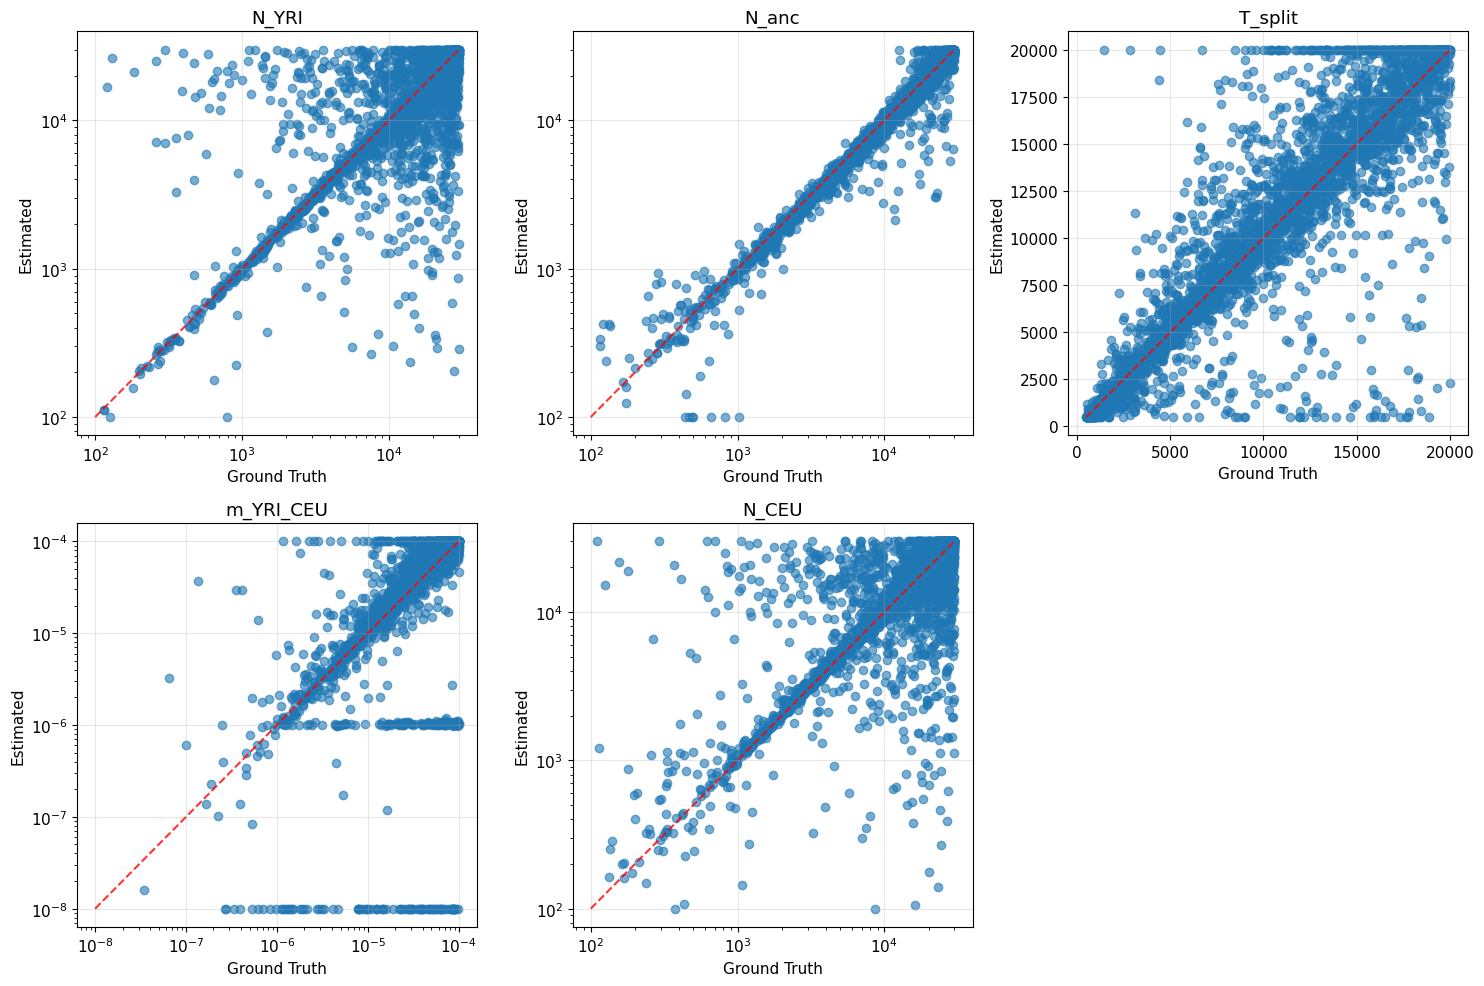

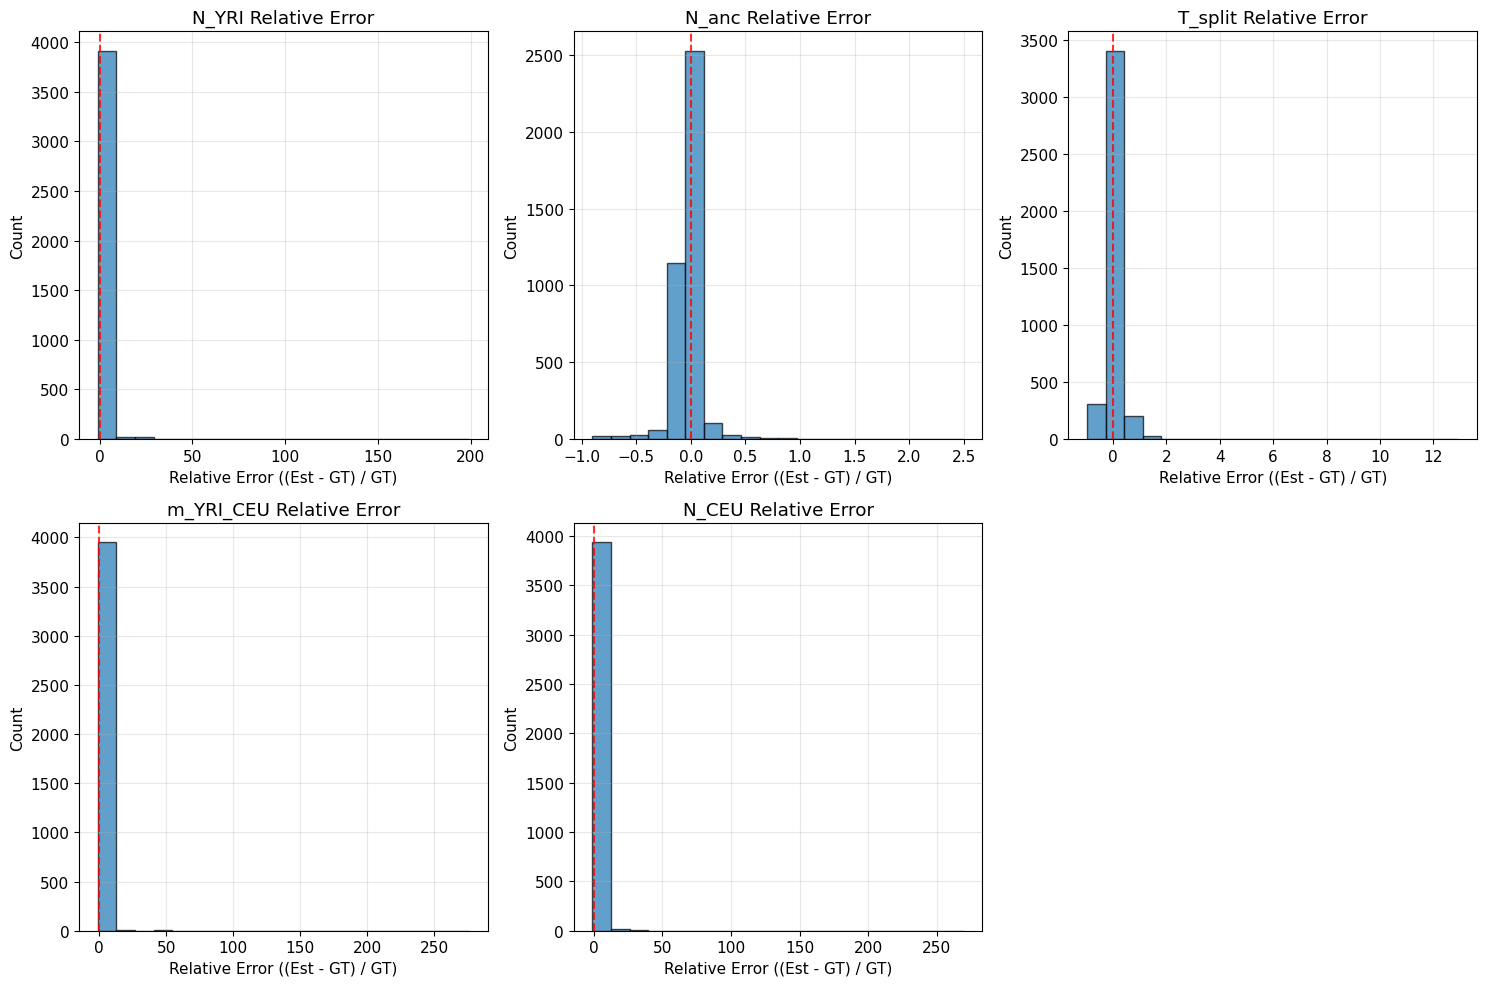

In [13]:
# Plotting
if not df.empty:
    parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
    print(f"Plotting {len(parameters)} parameters: {parameters}")
    
    # 1. Scatter plots: Ground Truth vs Estimated
    n_cols = 3
    n_rows = (len(parameters) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Scatter plot
        ax.scatter(subset['ground_truth'], subset['estimated'], alpha=0.6)
        
        # 1:1 line
        min_val = min(subset['ground_truth'].min(), subset['estimated'].min())
        max_val = max(subset['ground_truth'].max(), subset['estimated'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        ax.set_title(f'{param}')
        ax.set_xlabel('Ground Truth')
        ax.set_ylabel('Estimated')
        ax.grid(True, alpha=0.3)
        
        # Log scale if range is large
        if max_val / (min_val + 1e-9) > 100:
            ax.set_xscale('log')
            ax.set_yscale('log')
            
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    # 2. Relative Error Distributions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Histogram of relative error
        errors = subset['relative_error'].dropna()
        ax.hist(errors, bins=20, alpha=0.7, edgecolor='black')
        
        ax.axvline(0, color='r', linestyle='--', alpha=0.8)
        
        ax.set_title(f'{param} Relative Error')
        ax.set_xlabel('Relative Error ((Est - GT) / GT)')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
        
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

Plotting 5 parameters: ['N_YRI', 'N_anc', 'T_split', 'm_YRI_CEU', 'N_CEU']


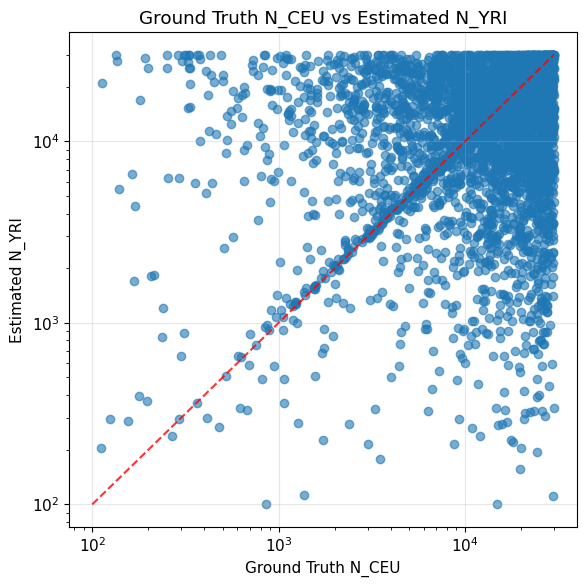

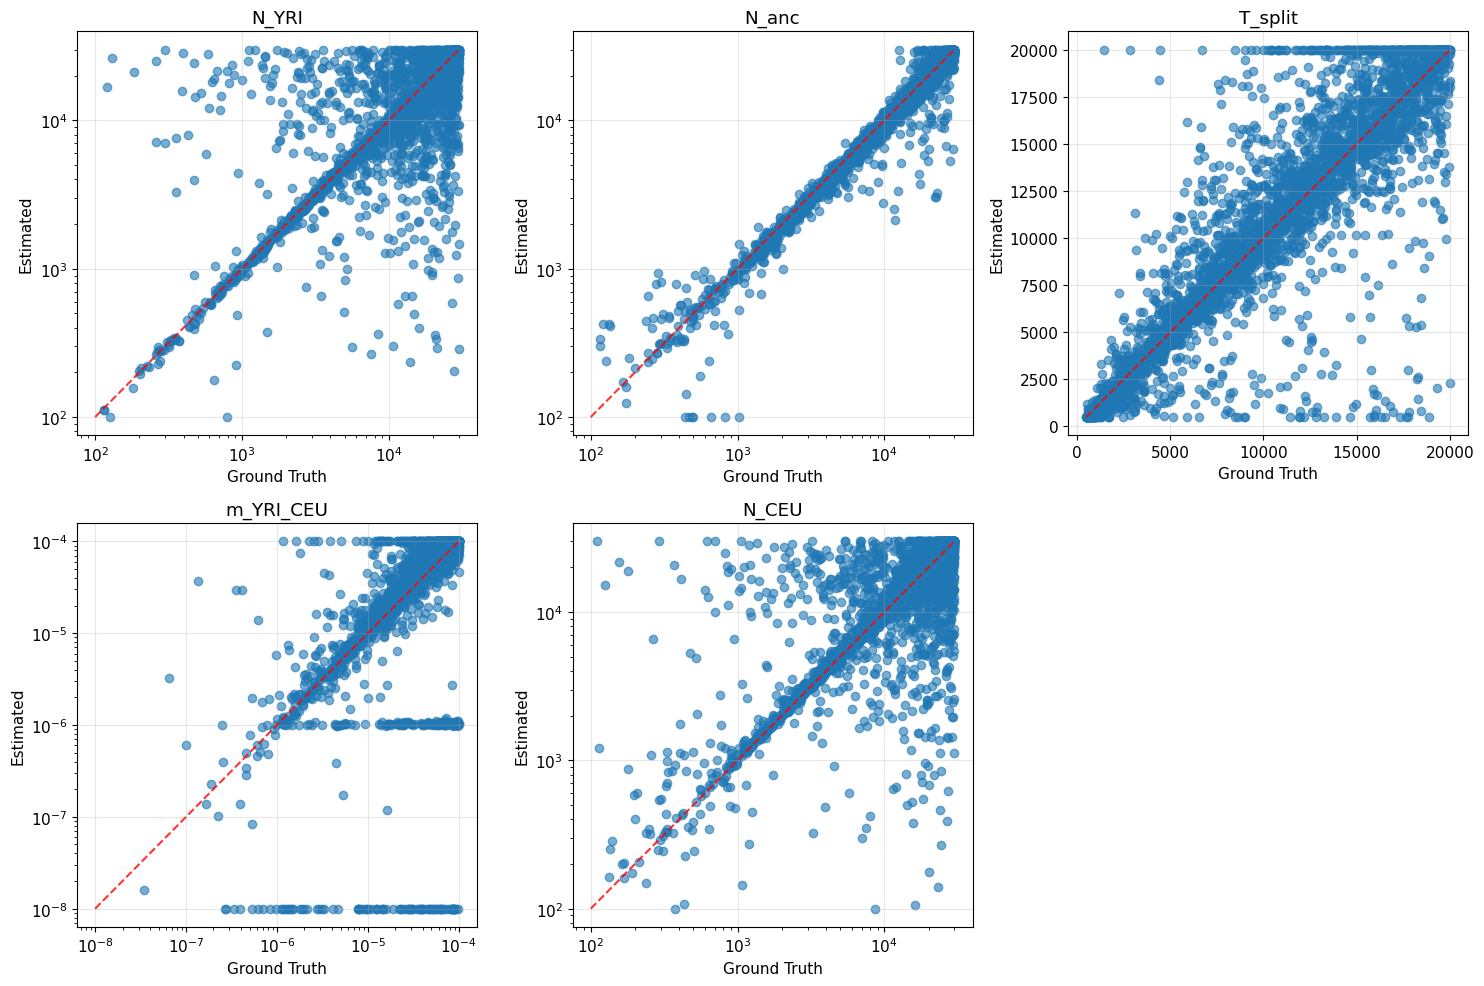

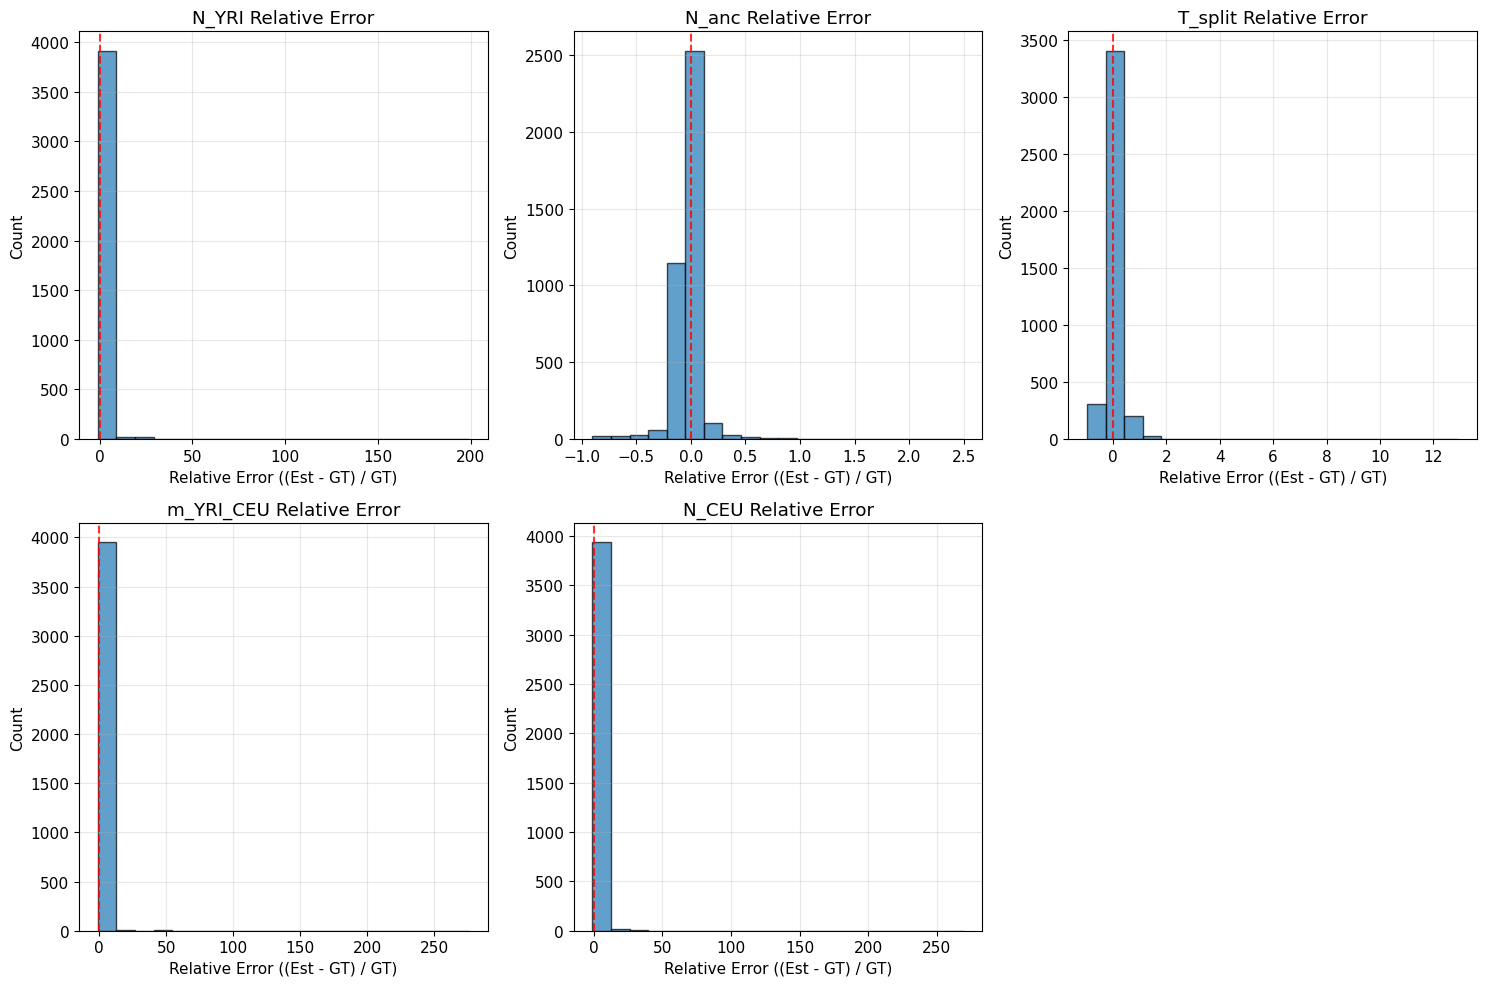

In [14]:
# Plotting
if not df.empty:
    parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
    print(f"Plotting {len(parameters)} parameters: {parameters}")
    
    # 0. SPECIAL CHECK: GT N_CEU vs EST N_YRI -----------------------------
    # Pivot to wide form: index = simulation, columns = parameter
    gt_wide = df.pivot(index='simulation', columns='parameter', values='ground_truth')
    est_wide = df.pivot(index='simulation', columns='parameter', values='estimated')

    if ('N_CEU' in gt_wide.columns) and ('N_YRI' in est_wide.columns):
        x = gt_wide['N_CEU']          # ground truth N_CEU
        y = est_wide['N_YRI']         # estimated N_YRI

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, alpha=0.6)

        # 1:1 line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        plt.xlabel('Ground Truth N_CEU')
        plt.ylabel('Estimated N_YRI')
        plt.title('Ground Truth N_CEU vs Estimated N_YRI')
        plt.grid(True, alpha=0.3)

        # Optional: log scale if huge dynamic range
        if max_val / (min_val + 1e-9) > 100:
            plt.xscale('log')
            plt.yscale('log')

        plt.tight_layout()
        plt.show()
    else:
        print("Could not find N_CEU or N_YRI columns for cross-plot; skipping.")
    # ---------------------------------------------------------------------

    # 1. Scatter plots: Ground Truth vs Estimated (per parameter)
    n_cols = 3
    n_rows = (len(parameters) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Scatter plot
        ax.scatter(subset['ground_truth'], subset['estimated'], alpha=0.6)
        
        # 1:1 line
        min_val = min(subset['ground_truth'].min(), subset['estimated'].min())
        max_val = max(subset['ground_truth'].max(), subset['estimated'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        ax.set_title(f'{param}')
        ax.set_xlabel('Ground Truth')
        ax.set_ylabel('Estimated')
        ax.grid(True, alpha=0.3)
        
        # Log scale if range is large
        if max_val / (min_val + 1e-9) > 100:
            ax.set_xscale('log')
            ax.set_yscale('log')
            
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    # 2. Relative Error Distributions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Histogram of relative error
        errors = subset['relative_error'].dropna()
        ax.hist(errors, bins=20, alpha=0.7, edgecolor='black')
        
        ax.axvline(0, color='r', linestyle='--', alpha=0.8)
        
        ax.set_title(f'{param} Relative Error')
        ax.set_xlabel('Relative Error ((Est - GT) / GT)')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
        
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
